# Arbeidskrav 5: 1005 Datavitenskap for økonomer

In [156]:
# Pakker

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import re



## Oppgave 1: Befolkningspyramide

In [157]:
# Laster inn csv-fil (excel)
# sep=";" sørger for at kolonnene blir separert i stedet for at alt står i en kolonne
A = pd.read_csv("/Users/eier/Downloads/aldersfordeling-for-innb.csv", sep=";")
A

,Alder,Kvinner,Menn
0,0-4 år,-599,593
1,5-9 år,-633,724
2,10-14 år,-775,823
3,15-19 år,-851,885
4,20-24 år,-692,766
5,25-29 år,-643,699
6,30-34 år,-728,744
7,35-39 år,-796,766
8,40-44 år,-772,727
9,45-49 år,-750,778


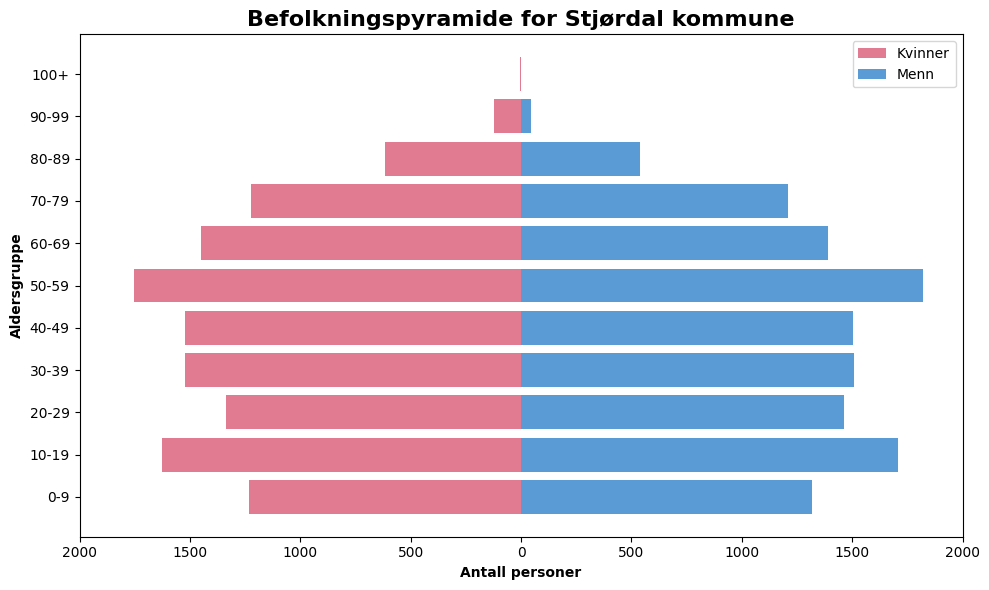

In [158]:

# Endrer på aldersgrupper til 10-års intervaller ved hjelp av en funksjon
def lag_aldergruppe(tekst):
    # Sjekker om verdien "tekst" er NaN, hvis den er det vil det stå "Ukjent"
    if pd.isna(tekst):
        return "Ukjent"
    
    # konverter til tekst hvis det er tall
    tekst = str(tekst)
    # Sørger for at verdien er en streng og ikke et heltatt slik at det blir behandlet riktig
    # text.split deler strengen tekst opp i separate ord basert på mellomrom, if is.digit sjekker om ordet kun består av et siffer, int(s) konverterer teksttall til faktisk heltall, altså integer (int).
    tall = [int(s) for s in re.findall(r"\d+", tekst)]  # Finner ALLE tall

    if not tall:
        return "Ukjent"
    
    # Henter det første tallet ut av listen "alder" for å vite hvilket aldersintervall det hører til
    alder = tall[0]
    # Hvis alderen er 100 eller høyere blir den sortert i gruppen 100+
    if alder >= 100:
        return "100+"
    # Tar alder og deler på 10 og tar kun heltallsdelen, d.v.s hvis den tar alder 23 delt på 10 får vi 2 ikke 2.3
    # * 10 gjør sånn at vi igjen får dele tallet, altså f. eks 20 i stedet for 2
    start = (alder // 10) * 10
    # Legger til 9 for å få med hele intervallet
    slutt = start + 9
    # Lager en f-streng som formatterer aldersintervallene i formen 20-29, 30-39 etc.
    return f"{start}-{slutt}"

# Lager en ny kolonne i datasettet for aldersgruppe
# Lager kolonnen "Aldersgruppe" ved å kjøre funksjonen lag_aldersgruppe på kolonnen "Alder" fra datasettet A
A["Aldersgruppe"] = A["Alder"].apply(lag_aldergruppe)

# Filtrerer bort eventuelle rader med ukjent-verdier
A = A[A["Aldersgruppe"] != "Ukjent"]

# Grupperer etter verdiene i "Aldersgruppe", altså alle rader som har samme aldersgruppe blir samlet inn i én gruppe
# sort=False sørger for at rekkefølgen beholdes slik sm i datasettet, i stedet for å bli sortert alfabetisk
# .agg(...) summerer alle verdiene i kolonnene "Kvinner" og "Menn" innenfor hver aldersgruppe
# reset_index flytter tilbake indeksen som ble fjernet av group.by
gruppe = A.groupby("Aldersgruppe", sort=False).agg({
    "Kvinner": "sum",
    "Menn": "sum"
}).reset_index()

# Oppretter dataframen "gruppe" og lagrer hjelpekolonnen "start" i gruppe
gruppe["start"] = (
    # Sorter etter første tall i aldersgruppe
    gruppe["Aldersgruppe"]
    # Bruker regex for å hente det første tallet i hver aldersgruppe (^ henter starten av strengen, \d+ henter ett eller flere tall)
    .str.extract(r"^(\d+)")
    # Konverterer til heltatt, Int64 tillater NaN-verdier 
    .astype("Int64")
    # Fyller 999 for gruppene som ikke har tall i starten (100+)
    .fillna(999)
)
# gruppe.sort_values("start") sorterer hele "gruppe" basert på "start"
# .drop(columns="start") fjerner "start" siden den bare ble brukt til sortering og ikke skal brukes til noe mer
gruppe = gruppe.sort_values("start").drop(columns="start")

# Plotter, velger størrelse på plottet
plt.figure(figsize=(10, 6))

# Lager horisontalt barplott med plt.barh
# Plotter aldersgruppe og Kvinner/Menn fra dataframen gruppe, velger farge og label
# Siden verdiene i kolonnen kvinne har minus foran seg legger det seg riktig vei i plottet slik at vi får en pyramide
plt.barh(gruppe["Aldersgruppe"], gruppe["Kvinner"], color="#e07b91", label="Kvinner")
plt.barh(gruppe["Aldersgruppe"], gruppe["Menn"], color="#5b9bd5", label="Menn")

# Justering av aksetekst og tittel, fontweight gjør skriften tjukk
plt.xlabel("Antall personer", fontweight="bold")
plt.ylabel("Aldersgruppe", fontweight="bold")
plt.title("Befolkningspyramide for Stjørdal kommune", fontsize=16, fontweight="bold")
# plt.legend legger til oversikten over av hvilken farge som er hvilket kjønn
plt.legend()

# Vis x-aksen med absoluttverdi så kvinner vises med positive tall
# Gir en liste med posisjonene til tick-verdiene på x-aksen, [0] sørger for at vi bare henter numerske verdier
xticks = plt.xticks()[0]
# Lager en ny liste med absoluttverdier (abs) av tallene, gjør at minustegnet fjernes fra aksen men at det fortsatt behandles som negative tall
plt.xticks(xticks, [abs(int(x)) for x in xticks])

# Viser plottet
plt.tight_layout()
plt.show()

In [159]:
# Finner antall innbyggere i Stjørdal

# abs(gruppe["Kvinner"]) gjør alle tall positive før summering
# .sum legger sammen alle tallene i kolonnene "Menn" og "Kvinner"
totalt_kvinner = abs(gruppe["Kvinner"]).sum()
totalt_menn = gruppe["Menn"].sum()
totalt = totalt_kvinner + totalt_menn

# Printer utregningene
print(f"Totalt antall kvinner: {totalt_kvinner}")
print(f"Totalt antall menn: {totalt_menn}")
print(f"Totalt antall innbyggere: {totalt}")

Totalt antall kvinner: 12413
Totalt antall menn: 12514
Totalt antall innbyggere: 24927


Dette stemmer overens med det som står på kommunefakta-siden til Stjørdal til SSB (i fjerde kvartal 2024)

## Oppgave 2: Innvandring
### 2.1: Pareto-diagram

In [160]:
# Laster inn data
B = pd.read_csv("/Users/eier/Downloads/personer-med-innvandrerb.csv", sep=";")
# Endrer kolonne 2025 til å hete Antall
B.rename(columns={"2025": "Antall"}, inplace=True)

B

,Land,Antall
0,Sverige,92
1,Litauen,93
2,Polen,231
3,Tyskland,54
4,Ukraina,426
5,Eritrea,220
6,Somalia,191
7,Irak,59
8,Pakistan,7
9,Syria,289


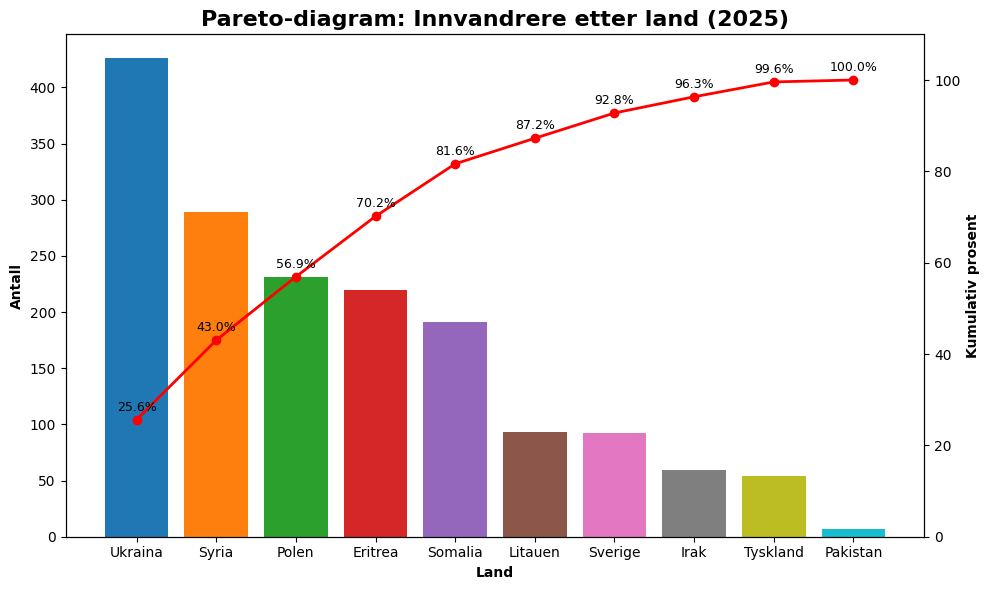

In [161]:

# Sorter etter antall i synkende rekkefølge, altså høyest først, reset_index for at indeksen skal starte på 0 igjen etter at den ble flyttet på, lagres i ny dataframe B_sorted
B_sorted = B.sort_values(by="Antall", ascending=False).reset_index(drop=True)
# Lager ny kolonne "Kumulativ prosent", cumsum lager en akkumulert sum (altså første rad = første tall, andre rad = første + andre tall osv.)
# Deler på totalen (Antall) for å få prosent, ganger med 100 for å få prosentverdier
B_sorted["Kumulativ prosent"] = B_sorted["Antall"].cumsum() / B_sorted["Antall"].sum() * 100

# Plottet
fig, ax1 = plt.subplots(figsize=(10, 6))

# Søylediagram – én søyle per land, med automatisk farge
# Løkke som går gjennom hver rad i B_sorted
# Farge på landene i plottet velges av seg selv siden jeg ikke spesifiserer noe i ax1.bar(...)
for i in range(len(B_sorted)):
    ax1.bar(B_sorted["Land"][i], B_sorted["Antall"][i])

# Velger tittel og etiketter
ax1.set_ylabel("Antall", fontweight="bold")
ax1.set_xlabel("Land", fontweight="bold")
ax1.set_title("Pareto-diagram: Innvandrere etter land (2025)", fontweight="bold", fontsize=16)

# Linje for kumulativ prosent
# Lager en ny akse ax2 som deler x-aksen med ax1(twinx)
ax2 = ax1.twinx()
# Lager en linje som viser kumulativ prosent
ax2.plot(B_sorted["Land"], B_sorted["Kumulativ prosent"], color="red", marker="o", linewidth=2)
# Etikette på linjen for kumulativ frekvens
ax2.set_ylabel("Kumulativ prosent", fontweight="bold")
# Setter grense til 110 prosent i stedet for 100 slik at det ser bedre ut og er enklere å lese av
ax2.set_ylim(0, 110)

# Legger prosenttallene over linja for kumulativ frekvens for bedre leselighet
# En løkke som går gjennom "Land" og "Kumulativ frekvens" samtidig, zip kombinerer to lister til par
# y + 2 gjør at teksten plasserer seg litt over selve punktet
# f"{y:.1f}%" formatrerer prsenttallet med én desimal og legger til prosenttegn, ha="center" sentrerer teksten horisontalt
for x, y in zip(B_sorted["Land"], B_sorted["Kumulativ prosent"]):
    ax2.text(x, y + 2, f"{y:.1f}%", ha="center", color="black", fontsize=9)

# Viser plottet
plt.tight_layout()
plt.show()

### 2.2: Kakediagram

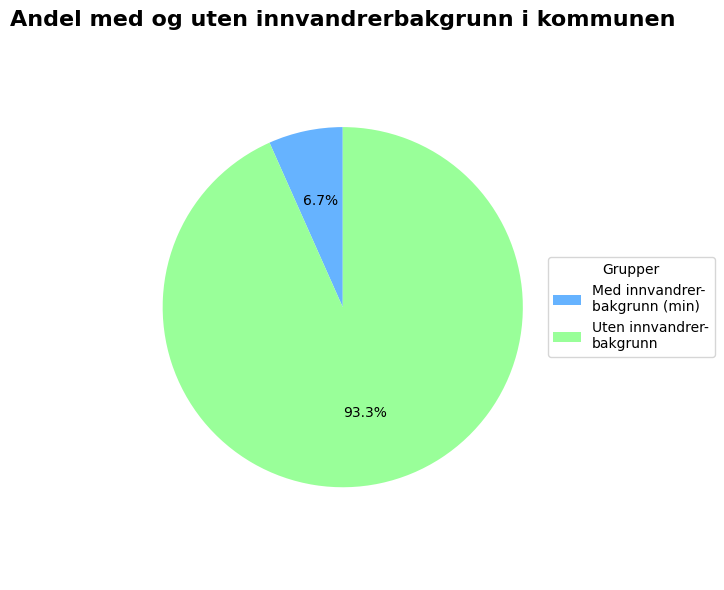

In [162]:

# Finner minimum antall innvandrere ved å legge sammen alle tallene i "Antall"-kolonnen
min_innvandrere = B_sorted["Antall"].sum()

# Totalt antall innbyggere ble regnet ut tidligere
totalt

# Beregner antall innbyggere utenom innvandrere
uten_innvandrere = totalt - min_innvandrere

# Velger verdiene som skal plottes og farger
verdier = [min_innvandrere, uten_innvandrere]
farger = ["#66b3ff", "#99ff99"]


# Oppretter figur
plt.figure(figsize=(6, 6))
# w, t og a er returverdier, w -> sektorer, t -> prosentetiketter, a -> etiketter (ikke i bruk her)
# autopct=... viser prosenter i sektoren med én desimal, startangle=90 gjør at inndelingen i diagrammet starter fra toppen, bruker fargene vi allerede definerte
w, t, a = plt.pie(verdier, autopct="%.1f%%", startangle=90, colors=farger)

# Velger etiketter som skal vises i legenden
# /n deler teksten til å gå over to linjer for bedre leselighet
etiketter = ["Med innvandrer-\nbakgrunn (min)", "Uten innvandrer-\nbakgrunn"]

# Legger til legende og velger titler og plasseringen av den, bbox_to_anchor... flytter legenden utenfor figuren og til høyre
plt.legend(etiketter, title="Grupper", loc="center left", bbox_to_anchor=(1, 0.5))
# Tittel på diagrammet
plt.title("Andel med og uten innvandrerbakgrunn i kommunen", fontweight="bold", fontsize=16)
# Gjør kakediagrammet rundt og ikke ovalt
plt.axis("equal")
plt.tight_layout()
plt.show()



## Oppgave 3: Arbeidsledighet

In [163]:

# Laster inn data
C = pd.read_csv("/Users/eier/Downloads/hva-innbyggerne-jobber-m.csv", sep=";")
C.rename(columns={"2020": "Antall"}, inplace=True)

C


,Næring,Antall
0,"Jordbruk, skogbruk og fiske",314
1,Sekundærnæringer,2345
2,"Varehandel, hotell og restaurant, samferdsel, ...",4404
3,"Off.adm., forsvar, sosialforsikring",773
4,Undervisning,1106
5,Helse- og sosialtjenester,2275
6,Personlig tjenesteyting,336


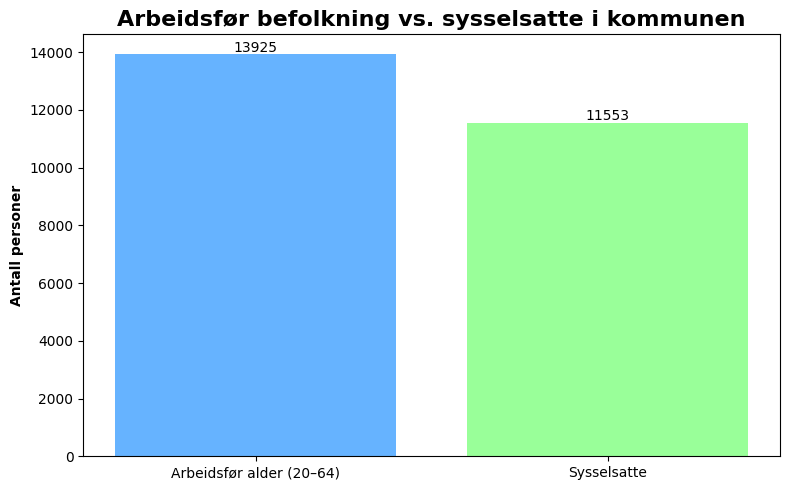

In [164]:

# Trekk ut startalder som heltall (f.eks. fra "20-24 år" → 20)
# Bruker regex til å finne det første tallet i teksten som er startalderen, expand=False gjør at vi får en kolonne og ikke en ny dataframe, as.type(int) gjør til integer
A["Startalder"] = A["Alder"].str.extract(r"(\d+)", expand=False).astype(int)

# Filtrer på startalder fra og med 20 til og med 60
arbeidsfør_df = A[(A["Startalder"] >= 20) & (A["Startalder"] <= 60)]

# Beregn antall personer i arbeidsfør alder, bruker abs på "Kvinner"-kolonnen siden den var negativ
arbeidsfør_antall = arbeidsfør_df["Kvinner"].abs().sum() + arbeidsfør_df["Menn"].sum()

# Finner antall sysselsatte ved å legge sammen alle ansatte innen de forskjellige næringene
sysselsatte_antall = C["Antall"].sum()

# Regner ut antall og andel utenfr arbeid
utenfor_arbeid = arbeidsfør_antall - sysselsatte_antall
andel_utenfor = utenfor_arbeid / arbeidsfør_antall * 100

# Velger hvilke verdier, etiketter og farger som skal plottes
verdier = [arbeidsfør_antall, sysselsatte_antall]
etiketter = ["Arbeidsfør alder (20–64)", "Sysselsatte"]
farger = ["#66b3ff", "#99ff99"]

# Velger bar-plot
plt.figure(figsize=(8, 5))
bars = plt.bar(etiketter, verdier, color=farger)

# Løkke som går gjennom hver stolpe
for bar in bars:
    # Brukes for å hente høyden på stolpen for å plassere teksten litt over
    yval = bar.get_height()
    # Plassering av og utseende på tekst over stolpen
    plt.text(bar.get_x() + bar.get_width()/2, yval + 100, f"{int(yval)}", ha="center", fontsize=10)

# Titler og aksetekst
plt.ylabel("Antall personer", fontweight="bold")
plt.title("Arbeidsfør befolkning vs. sysselsatte i kommunen", fontweight="bold", fontsize=16)
plt.tight_layout()
plt.show()


### 3.2: Kakediagram

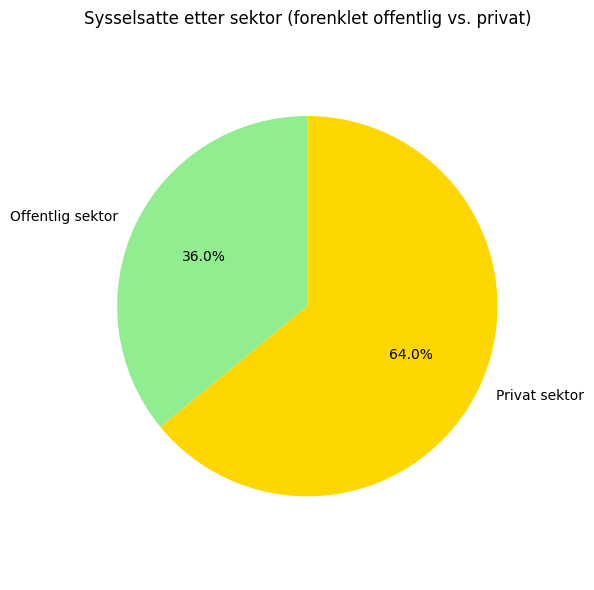

In [165]:

# Definer liste over næringer som tilhører offentlig sektor
offentlig_næringer = [
    "Helse- og sosialtjenester",
    "Undervisning",
    "Off.adm., forsvar, sosialforsikring"
]

# Lager en ny kolonne "Sektor" ut ifra kolonnen "Næring"
C["Sektor"] = C["Næring"].apply(
    # Hvis næringen er lik næringene i offentlig_næring blir det sortert som offentlig sektor, ellers privat sektor
    lambda x: "Offentlig sektor" if x in offentlig_næringer else "Privat sektor"
)

# Grupperer rader etter sektor, summerer antall sysselsatte i hver gruppe, gjør resultatet til en vanlig dataframe igjen med reset_index
sektor_data = C.groupby("Sektor")["Antall"].sum().reset_index()


# Verdier, etiketter og farger
verdier = sektor_data["Antall"]
etiketter = sektor_data["Sektor"]
farger = ["lightgreen", "gold"]

# Lager kakediagram
plt.figure(figsize=(6, 6))
plt.pie(verdier, labels=etiketter, autopct="%.1f%%", startangle=90, colors=farger)
plt.title("Sysselsatte etter sektor (forenklet offentlig vs. privat)")
plt.axis("equal")
plt.tight_layout()
plt.show()


## Oppgave 4: Utdanningsnivå
### 4.1. Kakediagram

In [166]:
# Laster inn data

D = pd.read_csv("/Users/eier/Downloads/hyeste-fullfrte-utdannin.csv", sep=";")
D

,Utdanningsnivå,Personer 16 år og over
0,Grunnskolenivå,4811
1,Videregående skolenivå,8456
2,"Universitets- og høgskolenivå, kort",4602
3,"Universitets- og høgskolenivå, lang",1531
4,Uoppgitt eller ingen fullført utdanning,74


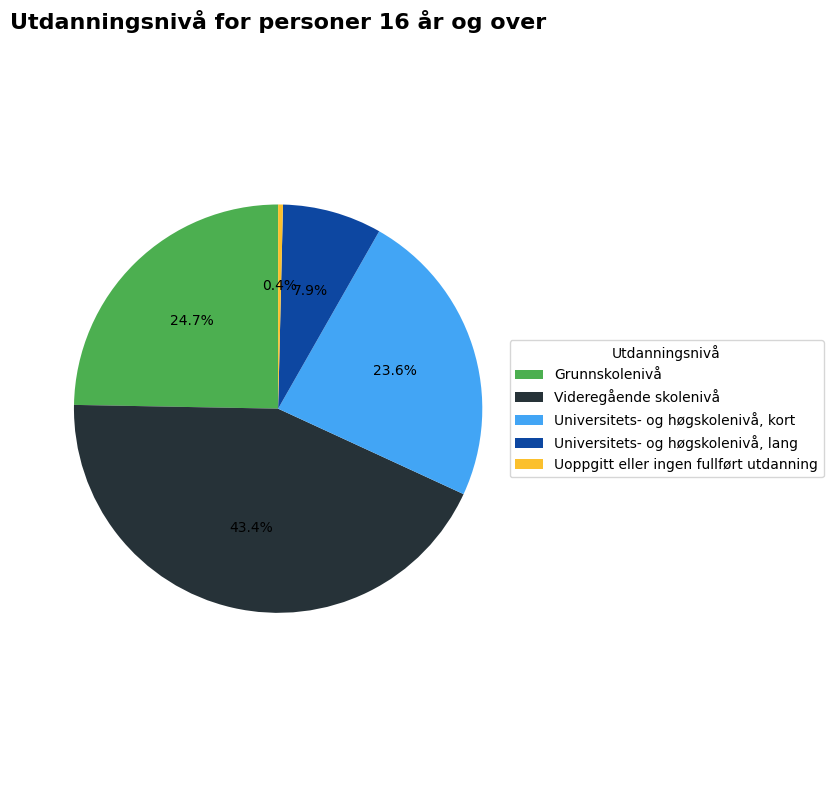

In [167]:

# Velger kolonnene som skal brukes
labels = D["Utdanningsnivå"]
values = D["Personer 16 år og over"]

# Velger farger
farger = ["#4CAF50", "#263238", "#42A5F5", "#0D47A1", "#FBC02D"]

# Plottet
plt.figure(figsize=(8, 8))
# plt.pie returnerer verdiene wedges, _ og autotexts, inneholder sektorene i diagrammet (wedges), etiketter (her ikke spesifisert) og text-objektene for prosentandelene
wedges, _, autotexts = plt.pie(
    values,
    # Velger at kun ett desimaltall skal vises
    autopct="%.1f%%",
    startangle=90,
    colors=farger
)

# Legger til legende
plt.legend(wedges, labels, title="Utdanningsnivå", loc="center left", bbox_to_anchor=(1, 0.5))

# Velger tittel og etiketter
plt.title("Utdanningsnivå for personer 16 år og over", fontweight="bold", fontsize=16)
plt.axis("equal")  # Sørger for sirkel
plt.tight_layout()
plt.show()



### 4.2: Stolpediagram

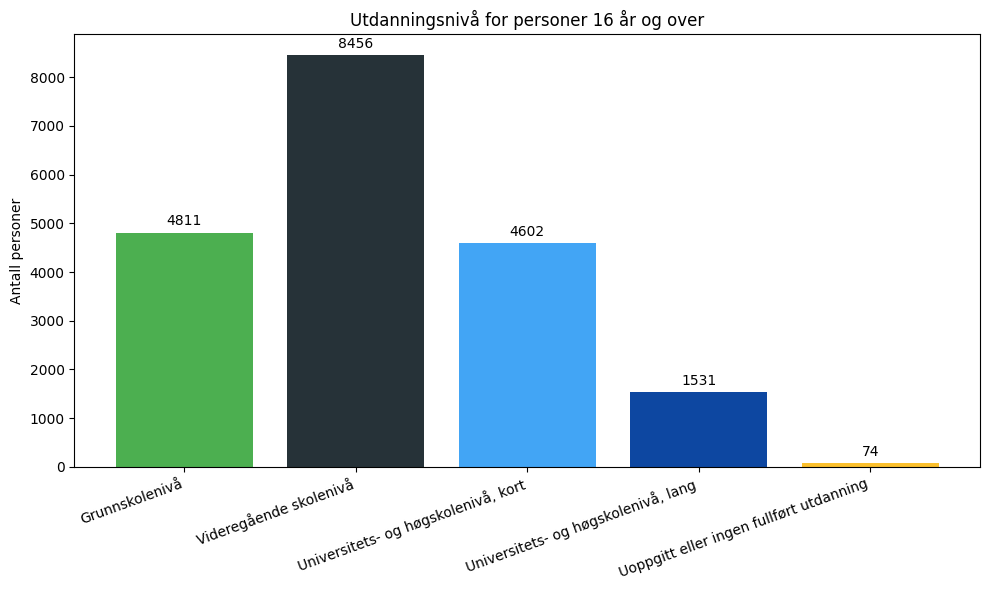

In [168]:
# Oppretter figur og akse
fig, ax = plt.subplots(figsize=(10, 6))

# Laer stolpediagram, velger parametere
bars = ax.bar(labels, values, color=farger)

# Legg til etiketter på stolpene – automatisk, padding=3 bestemmer hvor langt over stolpen teksten skal stå
ax.bar_label(bars, padding=3, fontsize=10)

# Tilpasser utseendet
ax.set_ylabel("Antall personer")
ax.set_title("Utdanningsnivå for personer 16 år og over")
# Roterer x-etikettene 20 grader mot høyre, ha="right" ankrer teksten på x-aksen slik at den ikke brer seg så langt ut til høyre
plt.xticks(rotation=20, ha="right")
plt.tight_layout()
plt.show()

### 4.3: Når skal man bruke kakediagram?

Det fine med et kakediagram er at man får et tydelig bilde på hvor mye de forskjellige faktorene tar opp av helheten. Problemer kan derimot oppstå når man prøver å se for mange faktorer samtidig ettersom at det blir vanskelig å lese av og uoversiktelig. Det kan altså være et nyttig verktøy, men det er også mange situasjoner hvir man kanskje helst burde velge en annen type diagram.

## 5: Kulturbudsjett
### 5.1: Avgjører størrelsen på kulturbudsjettet

In [169]:
# Laster inn data

E = pd.read_csv("/Users/eier/Downloads/hva-bruker-kommunen-kult.csv", sep=";")
E.rename(columns={"2024": "Kroner"}, inplace=True)

E

,Tjenesteområde,Kroner
0,Aktivitetstilbud barn og unge,101
1,Bibliotek,292
2,Muséer,69
3,Idrett og tilskudd til andres idrettsanlegg,75
4,Kommunale idrettsbygg og idrettsanlegg,902
5,Kulturskoler,377
6,Kommunale kulturbygg,990


In [170]:

# Summerer kolonnen kroner
total_kultur = E["Kroner"].sum()

# Tallene er gitt i kroner brukt per innbygger så jeg ganger "total" med antall innbyggere i Stjørdal som jeg fant tidligere
omt_budsjett = total_kultur * totalt
print(f"Omtrentlig størrelse på budsjettet er {omt_budsjett:.1f}")


Omtrentlig størrelse på budsjettet er 69945162.0


### 5.2: Andel brukt på å drifte kommunale idrettsbygg og anlegg

In [171]:

# Finner totalbusjettet ved å summere kolonnen "Kroner"
budsj_total = E["Kroner"].sum()

# Henter beløpet til "Kommunale idrettsbygg og idrettsanlegg" ved å hente ut raden "Kommunale idrettsbygg og idrettsanlegg" i kolonnen "Tjenesteområde" og henter selve tallet med .values
beløp_idrettsbygg = E.loc[E["Tjenesteområde"] == "Kommunale idrettsbygg og idrettsanlegg", "Kroner"].values[0]

# Beregner andelen
andel = beløp_idrettsbygg / budsj_total
# Ganger med 100 for å gjøre desimaltallet til prosentverdien
andel_prosent = andel * 100

# Printer svaret
print(f"Andel som går til kommunale idrettsbygg og anlegg: {andel_prosent:.1f}%")

Andel som går til kommunale idrettsbygg og anlegg: 32.1%


## Oppgave 6: Stjørdals utgifter etter utvalgte områder

In [172]:

# Laster inn data

F = pd.read_csv("/Users/eier/Downloads/utgifter-etter-utvalgte.csv", sep=";")
F.rename(columns={"2024": "Utgift"}, inplace=True)
F["Utgift"] = F["Utgift"].str.replace(",", ".").astype(float)

F


,Tjenesteområde,Utgift
0,Sosialsektoren samlet,4.9
1,Barnevern,2.3
2,"Vann, avløp, renovasjon, avfall (VAR)",6.2
3,"Administrasjon, kommune",3.4
4,"Kultursektoren, kommune",3.7
5,Barnehage,9.2
6,Grunnskole,16.5
7,Helse- og omsorg,27.7


In [173]:

# Legger sammen alle verdiene i "Utgift" for å finne hvor mange prosent som allerede er inkludert
inkludert = F["Utgift"].sum()

# Trekker summen fra 100 for å finne prosentandelen
andel = 100 - inkludert
print(f"Prosentandelen av kommunens utgifter som ikke er inkludert i datagrunnlaget er {andel:.1f}%")


Prosentandelen av kommunens utgifter som ikke er inkludert i datagrunnlaget er 26.1%


## Oppgave 7: Biltyper i kommunen
### 7.1: Andel hybridbiler

In [174]:
# Laster inn data
G = pd.read_csv("/Users/eier/Downloads/typer-av-biler-i-kommune.csv", sep=";")
G.rename(columns={"2024": "Antall"}, inplace=True)

G

,Drivstoff,Antall
0,Bensin,3419
1,Diesel,5409
2,El.,3810
3,Annet drivstoff,1650


In [175]:

# Ifølge ssb går hybridbiler under raden "annet driftstoff"

# Legger sammen alle bilene for å finne totalen biler i kommunen
total_bil = G["Antall"].sum()

# Definerer antallet hybrider
hybrid = G.loc[G["Drivstoff"] == "Annet drivstoff", "Antall"].values[0]

# Finner andelen hybrider
andel_hybrid = hybrid / total_bil
# Gjør til prosent
andel_hybrid_prosent = andel_hybrid * 100

# Printer svar med tekst
print(f"Andelen hybridbiler i Stjørdal kommune er {andel_hybrid_prosent:.1f}%")


Andelen hybridbiler i Stjørdal kommune er 11.5%


### 7.2: Antall biler per person i "kjørbar alder"

In [176]:

# Avgrenser aldersgruppen
kjørbar = A[(A["Startalder"] >= 20) & (A["Startalder"] < 80)]

# Definerer antallet personer i kjørbar alder
kjørbar_befolkning = kjørbar["Kvinner"].abs().sum() + kjørbar["Menn"].sum()

# Totalt antall biler i kommunen, allerede definert tidligere i oppgaven
total_bil

# Finner biler per person i kjørbar alder ved å dele total antall biler som eies på antall personer i kjørbar alder
biler_per_person = total_bil / kjørbar_befolkning
print(f"Biler per person i kjørbar alder er {biler_per_person:.2f}")



Biler per person i kjørbar alder er 0.81


## Oppgave 8: Funksjon
### 8.1: Lage og teste funksjon

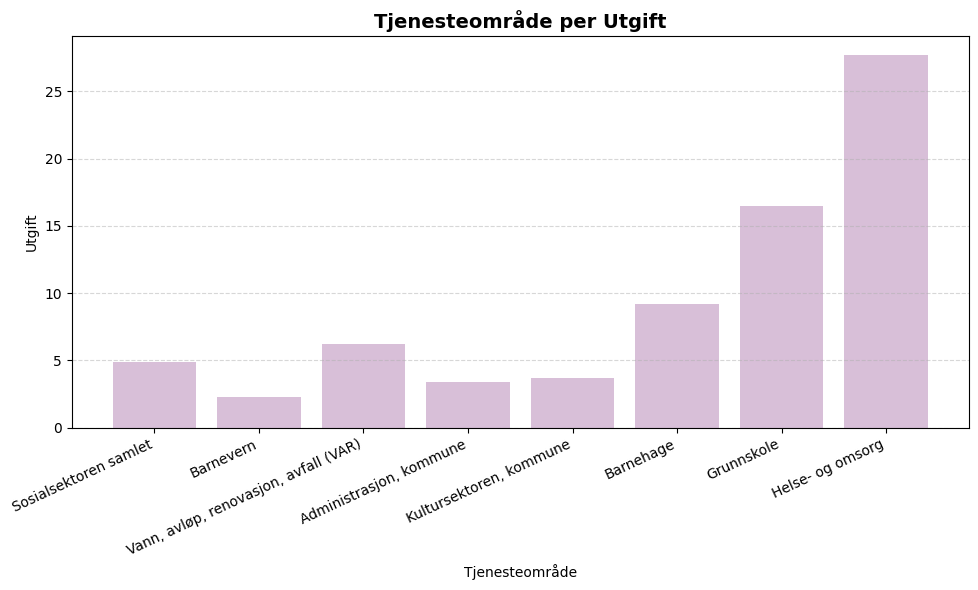

In [177]:
def plott_stolper(tabell):
    # henter kolonnenavnene som er første raden i tabellen
    kategori_navn = tabell.columns[0]
    verdi_navn = tabell.columns[1]

    # henter verdiene fra hver kolonne
    kategorier = tabell[kategori_navn]
    verdier = tabell[verdi_navn]

    # lager plottet
    plt.figure(figsize=(10, 6))
    bars = plt.bar(kategorier, verdier, color = "thistle")

    # henter tittel og aksetitler direkte fra tabellen
    plt.title(f"{kategori_navn} per {verdi_navn}", fontsize = 14, weight = "bold")
    plt.xlabel(kategori_navn)
    plt.ylabel(verdi_navn)
    # roterer teksten på x-aksen fordi mange tabeller har lange kategorinavn
    plt.xticks(rotation = 25, ha = 'right')
    plt.grid(axis = 'y', linestyle = '--', alpha = 0.5)
    plt.tight_layout()
    plt.show()

# bruker tabell F som eksempel
plott_stolper(F)

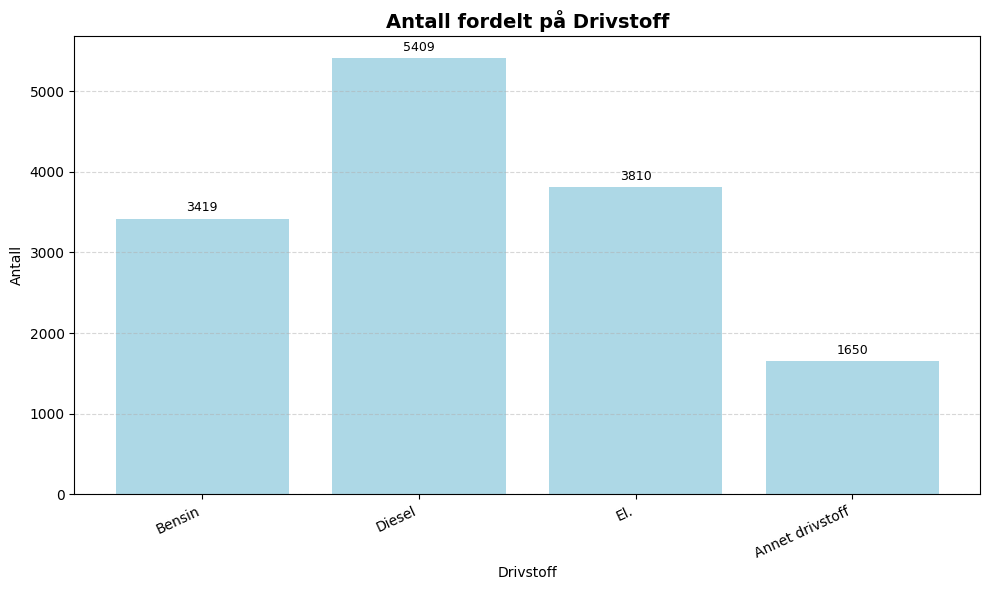

In [178]:

# Definerer funksjonen "plott_stolpediagram" som tar inn én input, en pandas dataframe kalt tabell
def plott_stolpediagram(tabell):
    # Første kolonne er kategoriern (blir x-akse) og andre er tallene (blir y-akse)
    kategori_kol = tabell.columns[0]
    verdi_kol = tabell.columns[1]

    # Henter verdiene fra tabellen
    x = tabell[kategori_kol]
    y = tabell[verdi_kol]

    # Oppretter figur (stolpediagram) og plot
    fig, ax = plt.subplots(figsize=(10, 6))
    bars = ax.bar(x, y, color="lightblue")

    # Sørger for at verdiene legger seg på toppen av stolpene
    ax.bar_label(bars, padding=3, fontsize=9)

    # Aksetitler og tittel
    ax.set_title(f"{verdi_kol} fordelt på {kategori_kol}", fontsize=14, weight="bold")
    ax.set_xlabel(kategori_kol)
    ax.set_ylabel(verdi_kol)

    # Plassering og rotering av skriften på x-aksen
    plt.xticks(rotation=25, ha="right")

    # Legger til rutenett på y-aksen
    ax.grid(axis="y", linestyle="--", alpha=0.5)

    # Viser plottet
    plt.tight_layout()
    plt.show()

plott_stolpediagram(G)

### 8.2: Hvorfor funksjonen ikke trenger et "return statement"

Return statement brukes til vanlig for å gi oss et tall som vi skal bruke i senere utregning, men her skal vi bare vise et plott. Dermed trenger vi ikke return. 

## Oppgave 9: Sammenligning av Stjørdal og Tromsø kommune
### 9.1: Sammenligning av utdanningsnivå

In [179]:
# laster inn data
TJ = pd.read_csv("/Users/eier/Downloads/hva-innbyggerne-jobber-m (1).csv", sep=";")
TJ.rename(columns={"2020": "Antall"}, inplace=True)

TJ

,Næring,Antall
0,"Jordbruk, skogbruk og fiske",670
1,Sekundærnæringer,5205
2,"Varehandel, hotell og restaurant, samferdsel, ...",15018
3,"Off.adm., forsvar, sosialforsikring",2729
4,Undervisning,5362
5,Helse- og sosialtjenester,11178
6,Personlig tjenesteyting,1691


In [180]:
# laster inn data
TU = pd.read_csv("/Users/eier/Downloads/hyeste-fullfrte-utdannin (1).csv", sep=";")
TU

,Utdanningsnivå,Personer 16 år og over
0,Grunnskolenivå,13373
1,Videregående skolenivå,19923
2,"Universitets- og høgskolenivå, kort",17859
3,"Universitets- og høgskolenivå, lang",12003
4,Uoppgitt eller ingen fullført utdanning,199


In [181]:
# laster inn data
TA = pd.read_csv("/Users/eier/Downloads/aldersfordeling-for-innb (1).csv", sep=";")
TA

,Alder,Kvinner,Menn
0,0-4 år,-1899,1997
1,5-9 år,-1936,1981
2,10-14 år,-2042,2223
3,15-19 år,-2218,2487
4,20-24 år,-2759,2671
5,25-29 år,-3474,3536
6,30-34 år,-3289,3591
7,35-39 år,-2843,2915
8,40-44 år,-2576,2726
9,45-49 år,-2433,2445


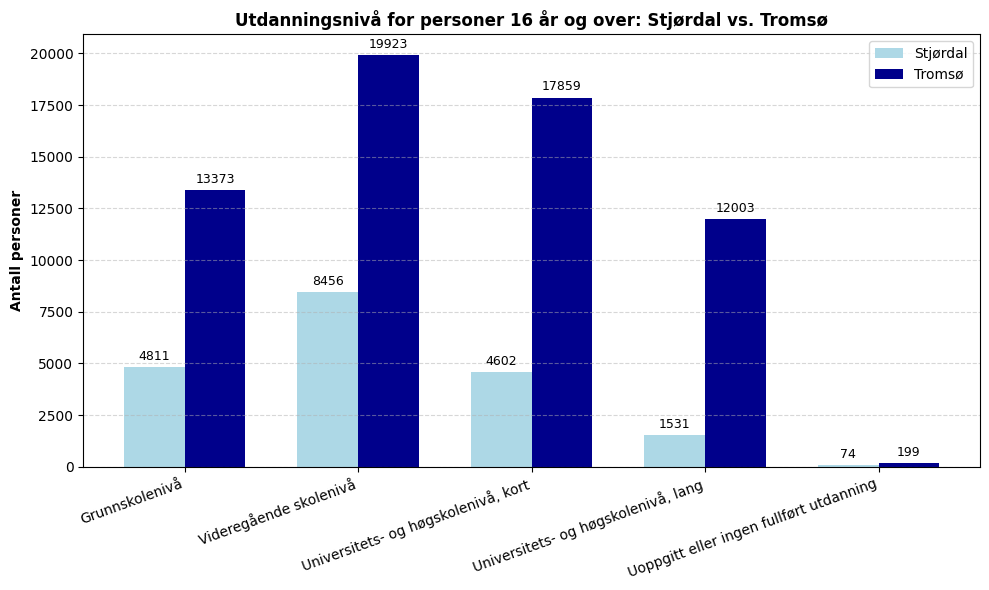

In [184]:
# Bar-plot som sammenligner

# Definerer kolonnen som skal brukes, både for etiketter og rekkefølge
nivåer = TU["Utdanningsnivå"] 

# Definerer kolonnenene som vi skal hente data fra
stjørdal = D["Personer 16 år og over"]
tromsø = TU["Personer 16 år og over"]

# Lager numeriske x-verdier
x = np.arange(len(nivåer))

# Oppretter plottet
fig, ax = plt.subplots(figsize=(10, 6))

# Plotter søylene
# x -/+ 0.35/2 flytter søylene for Stjørdal/Tromsø henholdsvis til høyre og venstre for at de skal vises ved siden av hverandre uten overlap
bars1 = ax.bar(x - 0.35/2, stjørdal, width = 0.35, label="Stjørdal", color="lightblue")
bars2 = ax.bar(x + 0.35/2, tromsø, width = 0.35, label="Tromsø", color="darkblue")

# Legger til skrift over søylene
ax.bar_label(bars1, padding=3, fontsize=9)
ax.bar_label(bars2, padding=3, fontsize=9)

# Tilpasninger
ax.set_ylabel("Antall personer", weight="bold")
ax.set_title("Utdanningsnivå for personer 16 år og over: Stjørdal vs. Tromsø", weight="bold")
ax.set_xticks(x)
ax.set_xticklabels(nivåer, rotation=20, ha="right")
ax.legend()
ax.grid(axis="y", linestyle="--", alpha=0.5)

plt.tight_layout()
plt.show()

### 9.2: Sammenligning av andel privat og offentlig sektor mellom Stjørdal og Tromsø

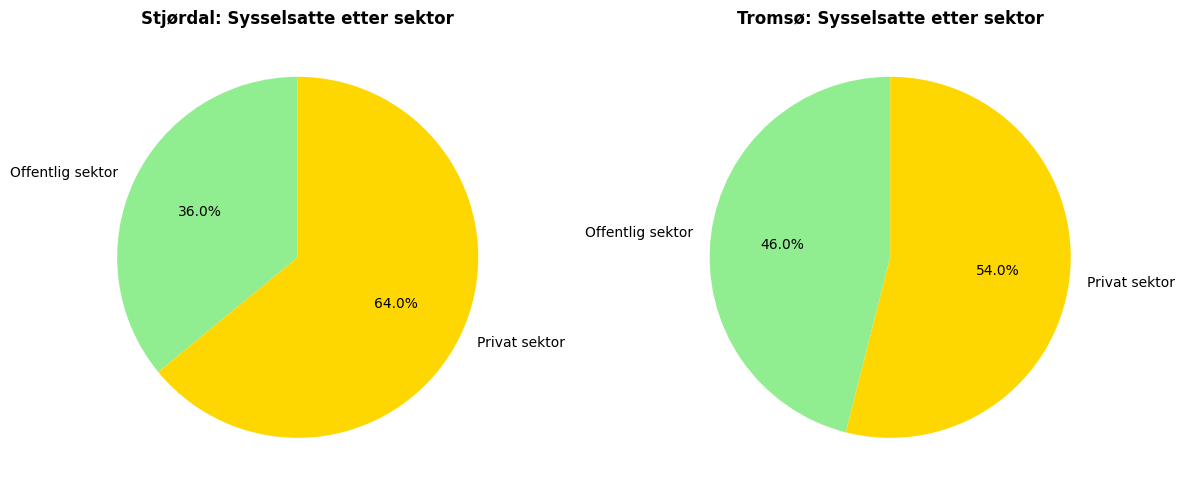

In [185]:

# Definerer sektordata for Stjørdal
sektor_data1 = C.groupby("Sektor")["Antall"].sum().reset_index()

# Legger til kolonne for privat/offentlig sektor i dataframen TJ (Tromsø)
TJ["Sektor"] = TJ["Næring"].apply(
    lambda x: "Offentlig sektor" if x in offentlig_næringer else "Privat sektor"
)
# Definerer sektordata for Tromsø
sektor_data2 = TJ.groupby("Sektor")["Antall"].sum().reset_index()

# Felles farger
farger = ["lightgreen", "gold"]

# Plotter begge kakediagrammene
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))

# Stjørdal
ax1.pie(
    sektor_data1["Antall"],
    labels=sektor_data1["Sektor"],
    autopct="%.1f%%",
    startangle=90,
    colors=farger
)
ax1.set_title("Stjørdal: Sysselsatte etter sektor", weight="bold")

# Tromsø
ax2.pie(
    sektor_data2["Antall"],
    labels=sektor_data2["Sektor"],
    autopct="%.1f%%",
    startangle=90,
    colors=farger
)
ax2.set_title("Tromsø: Sysselsatte etter sektor", weight="bold")

# Viser plottet
plt.tight_layout()
plt.show()

### 9.3: Sammenligne sysselsettingsstatus

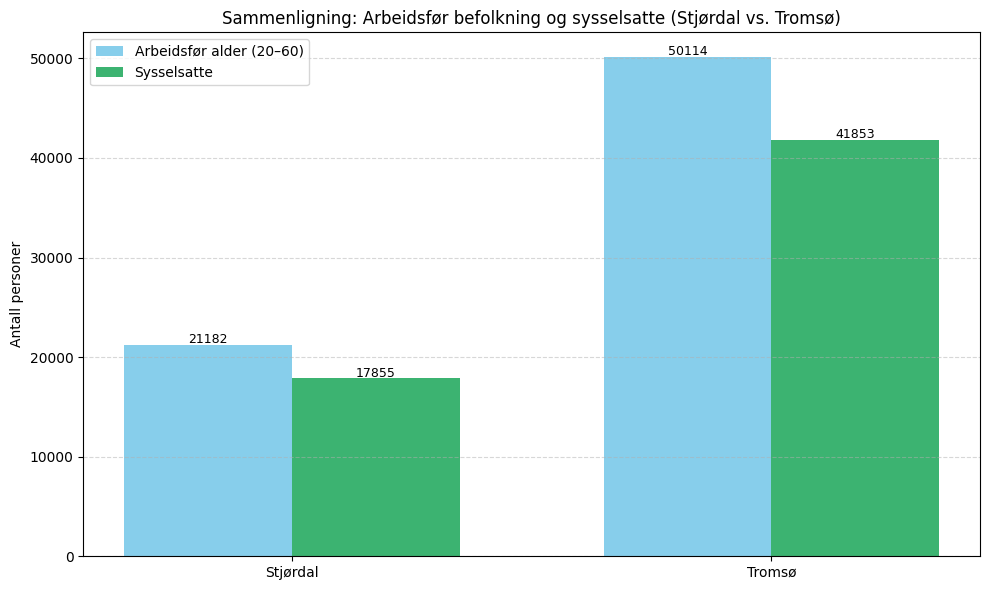

In [186]:


# Ekstraher startalder som tall
TA["Startalder"] = TA["Alder"].str.extract(r"(\d+)", expand=False).astype(int)

# Filtrerer arbeidsfør alder (20–60 år)
TA_arbeidsfør = TA[(TA["Startalder"] >= 20) & (TA["Startalder"] <= 60)]

# Beregner totalt antall personer i arbeidsfør alder
# Kvinner er negative i datasettet → bruk abs()
tromso_arbeidsfør_antall = TA_arbeidsfør["Kvinner"].abs().sum() + TA_arbeidsfør["Menn"].sum()

# Sysselsatte i Tromsø fra dataframen TJ
tromso_sysselsatte = TJ["Antall"].sum()

# Data for Stjørdal (fra tidligere)
stjørdal_arbeidsfør = 21182
stjørdal_sysselsatte = 17855

# Forbereder data til plottet
arbeidsfør = [stjørdal_arbeidsfør, tromso_arbeidsfør_antall]
sysselsatte = [stjørdal_sysselsatte, tromso_sysselsatte]
kommuner = ["Stjørdal", "Tromsø"]

# Lager stolpediagram
x = range(len(kommuner))
bredde = 0.35

fig, ax = plt.subplots(figsize=(10, 6))

bars1 = ax.bar([i - bredde/2 for i in x], arbeidsfør, width=bredde, label="Arbeidsfør alder (20–60)", color="skyblue")
bars2 = ax.bar([i + bredde/2 for i in x], sysselsatte, width=bredde, label="Sysselsatte", color="mediumseagreen")

# Legger på tall over stolpene
for bars in [bars1, bars2]:
    for bar in bars:
        yval = bar.get_height()
        ax.text(bar.get_x() + bar.get_width()/2, yval + 200, f"{int(yval)}", ha="center", fontsize=9)

# Tilpasninger
ax.set_xticks(x)
ax.set_xticklabels(kommuner)
ax.set_ylabel("Antall personer")
ax.set_title("Sammenligning: Arbeidsfør befolkning og sysselsatte (Stjørdal vs. Tromsø)")
ax.legend()
ax.grid(axis="y", linestyle="--", alpha=0.5)

plt.tight_layout()
plt.show()